# Importando as bibliotecas

In [4]:
import pandas as pd
from db import connection_db as conndb
from db import filters
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np

tqdm.pandas()

Conectando ao banco de dados do MongoDB

In [5]:
uri = 'mongodb://localhost:27017/'
db_name = 'dadosVivamente'
col_name = 'dadosSemFiltros'
col_filtrada = 'posts7anos1anos'

mongo_connection = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=col_name)
mongo_connection.connect()
collection = mongo_connection.collection

mongo_connection_filtrada = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=col_filtrada)
mongo_connection_filtrada.connect()
collection_filtrada = mongo_connection_filtrada.collection

Conexão estabelecida com sucesso ao banco de dados.
Conexão estabelecida com sucesso ao banco de dados.


Aplicando pipeline para preparação dos dados

In [6]:
collection_filters = filters.CollectionFilters(collection)

collection_filters_likes = filters.CollectionFilters(collection_filtrada)

# Aplicando pipeline 1
collection_filters.apply_pipeline1('dadosComFiltrosIniciais')

# Aplicando pipeline 2 - pega os posts que tenha a data de publicação de no máximo 7 anos e no mínimo 2 anos
collection_filters.apply_pipeline2(7, 1, 'posts7anos1anos')

# Aplicando pipeline 3 - desenrola os posts em documentos individuais e cria novas colunas
collection_filters.apply_pipeline3('postsComBDIAndInfos')

# Aplicando pipeline 4 - aplica o filtro para selecionar apenas os posts que tem uma data de publicação válida
collection_filters.apply_pipeline4('postsComBDIAndInfosFiltroDataPosts')

collection_filters_likes.apply_pipeline6('likes')

collection = collection_filters.collection

collection_filtrada = collection_filters_likes.collection

INFO:root:A coleção já existe: dadosComFiltrosIniciais
INFO:root:A coleção já existe: posts7anos1anos
INFO:root:A coleção já existe: postsComBDIAndInfos
INFO:root:A coleção já existe: postsComBDIAndInfosFiltroDataPosts
INFO:root:A coleção já existe: likes


In [7]:
documentos = collection.find()
df_original = pd.DataFrame(list(documentos))

In [8]:
# Visualizar as primeiras linhas do dataframe
df_original.head()

,_id,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,...,irritabilidade,apetite,concentracao,fadiga,int_sexo,quantAmigos,postMessage,postStory,postCreatedTime,diaDaSemana
0,5922035323c873001d525745,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,"Marry, acho mesmo que sou de exatas...rs",Michele Kreski shared a video to your Timeline.,2017-05-07 20:42:01,Domingo
1,5922035323c873001d525746,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,A foto não está muito boa (porque o foco é a b...,Michele Kreski with Stephani Kreski and 3 others.,2017-05-03 14:56:38,Quarta-feira
2,5922035323c873001d525747,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,Hahahahahaha,Thais Belarmino shared Paródia dos Nomes's pho...,2017-03-21 16:40:15,Terça-feira
3,5922035323c873001d525748,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,NaN,Daniel Brito and 10 others wrote on your Timel...,2017-03-12 00:35:55,Domingo
4,5922035323c873001d525749,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,Parabéns Mariana Kreski foto top hahahhahhahha...,NaN,2017-03-10 18:19:35,Sexta-feira


In [9]:
documentos_likes = collection_filtrada.find()
df_likes = pd.DataFrame(list(documentos_likes))

In [10]:
# Visualizar as primeiras linhas do dataframe
df_likes.head()

,_id,id_usuario,likeCreatedTime
0,5922035323c873001d52562f,1743509662331356,2017-05-18 23:31:26
1,5922035323c873001d525630,1743509662331356,2017-05-09 21:32:15
2,5922035323c873001d525631,1743509662331356,2017-05-02 21:16:06
3,5922035323c873001d525632,1743509662331356,2017-04-19 17:33:47
4,5922035323c873001d525633,1743509662331356,2017-04-12 11:23:27


In [11]:
# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima',
    'critica', 'suicida', 'choro', 'agitacao', 'interesse', 'indecisao',
    'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]


# Função para preencher valores nulos e converter o tipo de dado
def preencher_e_converter(df, colunas, valor_preenchimento=0, tipo_dados='int64'):
    df[colunas] = df[colunas].fillna(valor_preenchimento)
    df[colunas] = df[colunas].astype(tipo_dados)
    return df


# Aplicando a função
df_original = preencher_e_converter(df_original, colunas_para_converter)
df_original['sexo'] = df_original['sexo'].map({'F': 0, 'M': 1})

# Filtragem dos dados
df_original.drop(columns=['_id', 'diaDaSemana'], inplace=True)

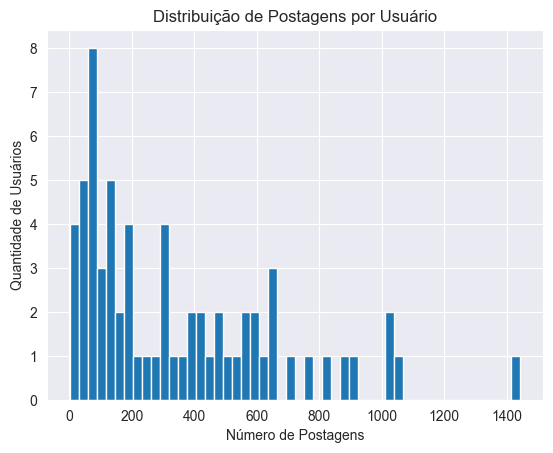

In [12]:
# Criando novas colunas com o pandas
df_original['data'] = df_original['postCreatedTime'].dt.date
df_original['data'] = pd.to_datetime(df_original['data'])
df_original['mes'] = df_original['data'].dt.to_period('M')
df_original['semana'] = df_original['data'].dt.to_period('W')

# Filtrar posts do ano de 2017, exceto dezembro
df_2017 = df_original[df_original['data'].dt.year == 2017]
df_2017 = df_2017[~((df_2017['data'].dt.month == 12) & (df_2017['data'].dt.year == 2017))]
df_2017 = df_2017[df_2017['data'].dt.month >= 5]
df_2017 = df_2017[df_2017['suicida'] == 3]

# Remover linhas onde ambas as colunas 'postMessage' e 'postStory' estão vazias ou nulas
df_2017 = df_2017.dropna(subset=['postMessage', 'postStory'], how='all')  # Remove quando ambas são NaN
df_2017 = df_2017[~((df_2017['postMessage'].str.strip() == '') & (
        df_2017['postStory'].str.strip() == ''))]  # Remove quando ambas são strings vazias

# Calcular a contagem de postagens por usuário
post_counts = df_2017.groupby('id_usuario').size().reset_index(name='post_count')

# Visualizar a distribuição
plt.hist(post_counts['post_count'], bins=50)
plt.xlabel('Número de Postagens')
plt.ylabel('Quantidade de Usuários')
plt.title('Distribuição de Postagens por Usuário')
plt.show()

In [13]:
# Definir os limites superior e inferior
limite_superior = post_counts['post_count'].quantile(0.85)
limite_inferior = post_counts['post_count'].quantile(0.15)

# Filtrar usuários com alta atividade
usuarios_alta_ativ = post_counts[post_counts['post_count'] > limite_superior]['id_usuario']

# Filtrar usuários com baixa atividade
usuarios_baixa_ativ = post_counts[post_counts['post_count'] < limite_inferior]['id_usuario']

# Exibir o número de usuários filtrados
print(f'Número de usuários com alta atividade: {len(usuarios_alta_ativ)}')
print(f'Número de usuários com baixa atividade: {len(usuarios_baixa_ativ)}')

Número de usuários com alta atividade: 10
Número de usuários com baixa atividade: 10


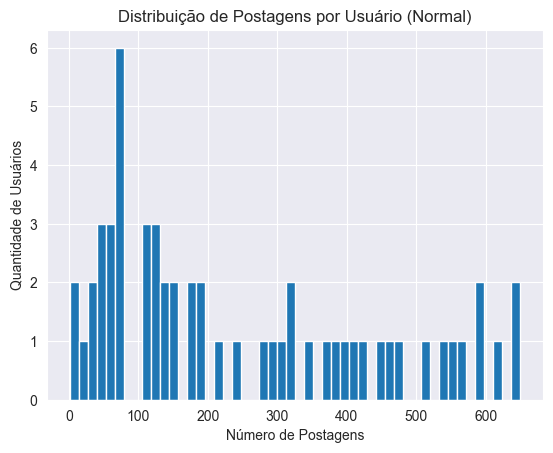

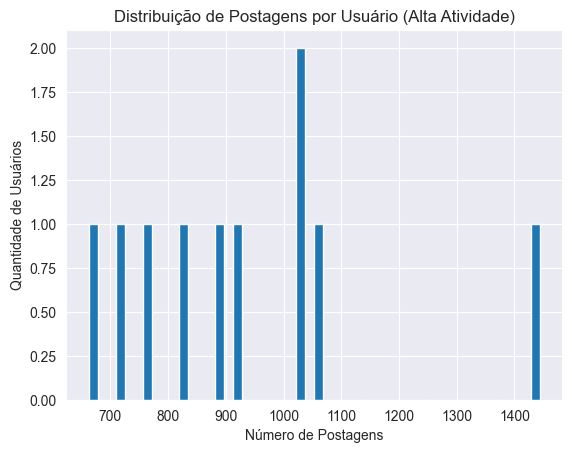

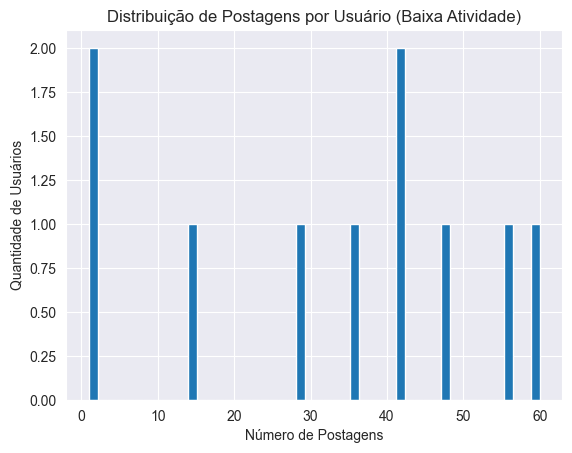

In [14]:
df_normal = df_2017[~(df_2017['id_usuario'].isin(usuarios_alta_ativ))]

# df_normal = df_2017[
#     ~(df_2017['id_usuario'].isin(usuarios_alta_ativ) | df_2017['id_usuario'].isin(usuarios_baixa_ativ))]

norm_post_count = df_normal.groupby('id_usuario').size().reset_index(name='post_count')

df_alta_ativ = df_2017[df_2017['id_usuario'].isin(usuarios_alta_ativ)]
alt_post_count = df_alta_ativ.groupby('id_usuario').size().reset_index(name='post_count')

df_baixa_ativ = df_2017[df_2017['id_usuario'].isin(usuarios_baixa_ativ)]
baixa_post_count = df_baixa_ativ.groupby('id_usuario').size().reset_index(name='post_count')


def plotar_distribuicao(post_count_df, titulo):
    plt.hist(post_count_df['post_count'], bins=50)
    plt.xlabel('Número de Postagens')
    plt.ylabel('Quantidade de Usuários')
    plt.title(titulo)
    plt.show()


plotar_distribuicao(norm_post_count, 'Distribuição de Postagens por Usuário (Normal)')
plotar_distribuicao(alt_post_count, 'Distribuição de Postagens por Usuário (Alta Atividade)')
plotar_distribuicao(baixa_post_count, 'Distribuição de Postagens por Usuário (Baixa Atividade)')

In [15]:
df_normal.head()

,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,...,concentracao,fadiga,int_sexo,quantAmigos,postMessage,postStory,postCreatedTime,data,mes,semana
61757,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,NaN,Gabriela Tedesco shared Chloe's photo.,2017-06-08 16:01:43,2017-06-08,2017-06,2017-06-05/2017-06-11
61758,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Mini pizza 😍😍😍,NaN,2017-06-08 15:56:50,2017-06-08,2017-06,2017-06-05/2017-06-11
61759,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Os pães de hj 😍😘😍,NaN,2017-06-08 01:51:16,2017-06-08,2017-06,2017-06-05/2017-06-11
61760,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Amo um carinho da minha mãe 😍😍😍,NaN,2017-06-08 01:12:01,2017-06-08,2017-06,2017-06-05/2017-06-11
61761,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,NaN,Gabriela Tedesco shared Chloe's photo.,2017-06-07 23:41:27,2017-06-07,2017-06,2017-06-05/2017-06-11


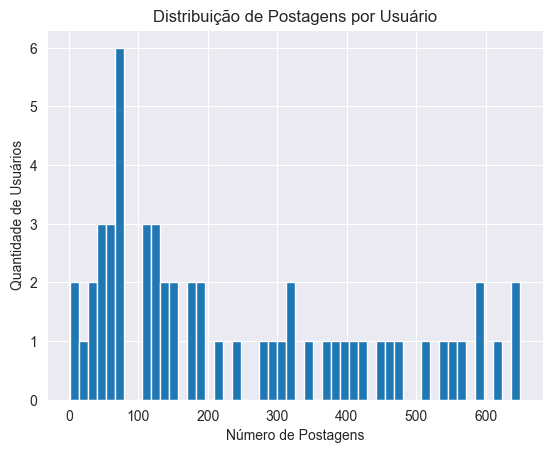

In [16]:
# Calcular a contagem de postagens por usuário
post_counts_normal = df_normal.groupby('id_usuario').size().reset_index(name='post_count')

# Visualizar a distribuição
plt.hist(post_counts_normal['post_count'], bins=50)
plt.xlabel('Número de Postagens')
plt.ylabel('Quantidade de Usuários')
plt.title('Distribuição de Postagens por Usuário')
plt.show()

cluster
3    17
0    16
2    12
1    11
Name: count, dtype: int64


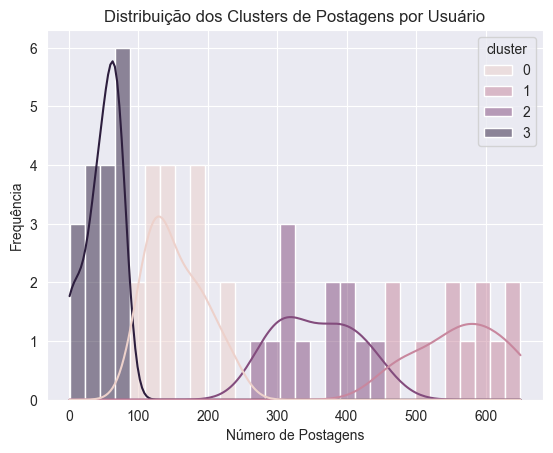

In [17]:
# Treinar o K-Means com o número de postagens dos usuários
kmeans = KMeans(n_clusters=4, random_state=0)
post_counts_normal['cluster'] = kmeans.fit_predict(post_counts_normal[['post_count']])

# Exibir a contagem de usuários por cluster
print(post_counts_normal['cluster'].value_counts())

# Plotar os clusters identificados
sns.histplot(data=post_counts_normal, x='post_count', hue='cluster', bins=30, kde=True)
plt.xlabel('Número de Postagens')
plt.ylabel('Frequência')
plt.title('Distribuição dos Clusters de Postagens por Usuário')
plt.show()

In [18]:
# Calcular o Silhouette Score
silhouette_avg = silhouette_score(post_counts_normal[['post_count']], kmeans.labels_)
print(f'Silhouette Score médio: {silhouette_avg}')

# Inércia (soma das distâncias quadradas internas)
print(f'Inércia do modelo: {kmeans.inertia_}')

Silhouette Score médio: 0.6001638969686159
Inércia do modelo: 106084.57754010695


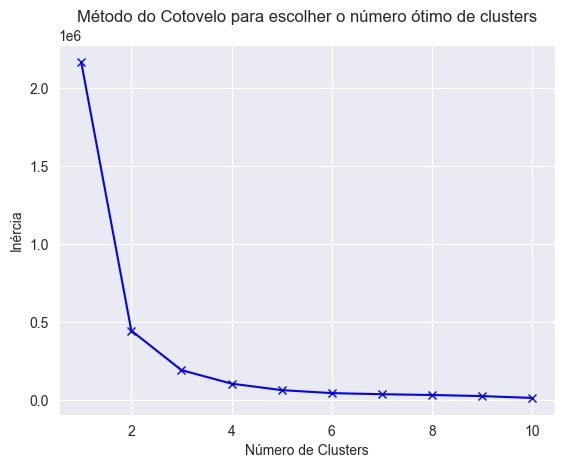

In [19]:
inercia = []
K = range(1, 11)  # Testar de 1 a 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(post_counts_normal[['post_count']])
    inercia.append(kmeans.inertia_)

# Plotar a inércia para diferentes números de clusters
plt.plot(K, inercia, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para escolher o número ótimo de clusters')
plt.show()

In [20]:
# Calcula as distâncias intracluster (distâncias entre pontos e seus centróides)
distancias_intracluster = cdist(post_counts_normal[['post_count']], kmeans.cluster_centers_[kmeans.labels_],
                                'euclidean')
media_intracluster = distancias_intracluster.mean()

# Calcula as distâncias intercluster (distâncias entre os centróides dos clusters)
distancias_intercluster = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
media_intercluster = distancias_intercluster[np.triu_indices_from(distancias_intercluster, 1)].mean()

print(f'Média das distâncias intracluster: {media_intracluster}')
print(f'Média das distâncias intercluster: {media_intercluster}')

Média das distâncias intracluster: 219.24362244897958
Média das distâncias intercluster: 254.88238095238097


Likes

In [ ]:
# Adicinando colunas no df_likes
df_likes['data'] = df_likes['likeCreatedTime'].dt.date
df_likes['data'] = pd.to_datetime(df_likes['data'])
df_likes['mes'] = df_likes['data'].dt.to_period('M')
df_likes['semana'] = df_likes['data'].dt.to_period('W')

df_likes_2017 = df_likes[df_likes['data'].dt.year == 2017]
df_likes_2017 = df_likes_2017[~((df_likes_2017['data'].dt.month == 12) & (df_likes_2017['data'].dt.year == 2017))]
df_likes_2017 = df_likes_2017[df_likes_2017['data'].dt.month >= 5]
df_likes_2017 = df_likes_2017

# Filtrar pelos likes dos id_usuarios que estão no df_2017
df_likes_2017 = df_likes_2017[df_likes_2017['id_usuario'].isin(df_normal['id_usuario'])]
df_likes_2017.head()
# Calcular a contagem de postagens por usuário
likes_counts = df_likes_2017.groupby('id_usuario').size().reset_index(name='like_count')

# Visualizar a distribuição
plt.hist(likes_counts['like_count'], bins=50)
plt.xlabel('Número de Likes')
plt.ylabel('Quantidade de Usuários')
plt.title('Distribuição de Likes por Usuário')
plt.show()

In [21]:
# Criar um dataframe para conter as colunas que não mudam e o id_usuario
df_respostas_bdi = df_normal.groupby(['id_usuario']).agg(
    pessimismo=('pessimismo', 'first'),
    tristeza=('tristeza', 'first'),
    fracasso=('fracasso', 'first'),
    prazer=('prazer', 'first'),
    culpa=('culpa', 'first'),
    punicao=('punicao', 'first'),
    estima=('estima', 'first'),
    critica=('critica', 'first'),
    suicida=('suicida', 'first'),
    choro=('choro', 'first'),
    agitacao=('agitacao', 'first'),
    interesse=('interesse', 'first'),
    indecisao=('indecisao', 'first'),
    desvalorizacao=('desvalorizacao', 'first'),
    energia=('energia', 'first'),
    sono=('sono', 'first'),
    irritabilidade=('irritabilidade', 'first'),
    apetite=('apetite', 'first'),
    concentracao=('concentracao', 'first'),
    fadiga=('fadiga', 'first'),
    int_sexo=('int_sexo', 'first'),
).reset_index()

df_respostas_bdi.to_csv('df_respostas_bdi.csv', index=False)

# Visualizar as primeiras linhas do dataframe
df_respostas_bdi.head()

,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,critica,suicida,...,interesse,indecisao,desvalorizacao,energia,sono,irritabilidade,apetite,concentracao,fadiga,int_sexo
0,1022864967872047,1,1,3,2,2,1,2,3,3,...,1,1,2,1,1,1,2,2,1,0
1,1044942355647418,0,1,3,1,1,2,0,3,3,...,2,1,1,2,3,1,1,2,0,3
2,1105432349559329,1,2,2,3,2,3,2,2,3,...,2,1,1,2,2,2,3,2,3,3
3,1170510339747390,2,3,3,2,1,0,3,2,3,...,2,3,3,3,3,2,2,3,3,2
4,1211223432346372,1,1,3,2,3,2,3,3,3,...,2,3,2,2,2,3,3,2,3,1


In [ ]:
# Remover a coluna 'id_usuario'
df_media_respostas_bdi = df_respostas_bdi.drop(columns=['id_usuario'])

# Calcular a média de cada resposta do BDI
media_respostas_bdi = df_media_respostas_bdi.mean()

# Visualizar as médias
print(media_respostas_bdi)

# Plotar as médias
plt.figure(figsize=(10, 6))
media_respostas_bdi.plot(kind='bar')
plt.xlabel('Pergunta')
plt.ylabel('Média da Resposta')
plt.title('Média das Respostas do BDI')
plt.show()

In [ ]:
df_normal = df_normal.copy()
df_normal.drop(
    columns=['pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida',
             'choro', 'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade',
             'apetite', 'concentracao', 'fadiga', 'int_sexo'], inplace=True)

df_alta_ativ = df_alta_ativ.copy()
df_alta_ativ.drop(
    columns=['pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida',
             'choro', 'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade',
             'apetite', 'concentracao', 'fadiga', 'int_sexo'], inplace=True)

df_baixa_ativ = df_baixa_ativ.copy()
df_baixa_ativ.drop(
    columns=['pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida',
             'choro', 'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade',
             'apetite', 'concentracao', 'fadiga', 'int_sexo'], inplace=True)

In [ ]:
# Agrupar as postagens por id_usuario e por período (ex: mês)
posts_por_mes = df_2017.groupby(['id_usuario', df_2017['data'].dt.to_period('M')])[
    'postCreatedTime'].count().reset_index()

# Renomear as colunas para ficar mais claro
posts_por_mes.columns = ['id_usuario', 'mes', 'post_count']

# Exibir os primeiros resultados
print(posts_por_mes.head())

In [ ]:
# Definir os meses para padronizar a matriz (supondo que seu período é mês)
meses_disponiveis = pd.period_range(start='2017-05', end='2017-11', freq='M')

# Pivotar os dados para criar uma matriz de séries temporais
# Cada linha é um usuário e cada coluna é o número de postagens em um mês específico
serie_temporal_matriz = posts_por_mes.pivot_table(index='id_usuario', columns='mes', values='post_count', fill_value=0)

# Garantir que todas as colunas (meses) estão presentes
serie_temporal_matriz = serie_temporal_matriz.reindex(columns=meses_disponiveis, fill_value=0)

# Exibir as primeiras linhas da matriz de séries temporais
serie_temporal_matriz.to_csv('serie_temporal_matriz.csv')
serie_temporal_matriz.head()

In [ ]:
# Definir o número de clusters
num_clusters = 3

# Inicializar o StandardScaler
scaler = StandardScaler()

# Ajustar e transformar os dados para escalar as contagens de postagens
serie_temporal_matriz_scaled = scaler.fit_transform(serie_temporal_matriz)

# Treinar o K-Means com os dados escalados
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(serie_temporal_matriz_scaled)

# Adicionar o rótulo do cluster ao dataframe original (antes da escala, para manter as contagens reais)
serie_temporal_matriz['cluster'] = kmeans.labels_

# Exibir quantos usuários estão em cada cluster
print(serie_temporal_matriz['cluster'].value_counts())

# Visualizar os centroides dos clusters (os padrões médios de cada grupo)
centroides = kmeans.cluster_centers_

for i in range(num_clusters):
    plt.plot(meses_disponiveis.astype(str), centroides[i], label=f'Cluster {i}')

plt.xlabel('Mês')
plt.ylabel('Número médio de postagens (escalado)')
plt.title('Centroides dos clusters de usuários')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Salvar em um dataframe os clusters
serie_temporal_matriz.to_csv('serie_temporal_matriz.csv')

In [ ]:
print(f'Inércia do modelo: {kmeans.inertia_}')

In [ ]:
# Avaliar a qualidade dos clusters com o coeficiente de silhueta
silhouette_avg = silhouette_score(serie_temporal_matriz.drop('cluster', axis=1), kmeans.labels_)
print(f'Silhouette Score médio: {silhouette_avg}')

In [ ]:
# Calcula as distâncias intracluster (distâncias entre pontos e seus centróides)
distancias_intracluster = cdist(serie_temporal_matriz.drop('cluster', axis=1), kmeans.cluster_centers_[kmeans.labels_],
                                'euclidean')
media_intracluster = distancias_intracluster.mean()

# Calcula as distâncias intercluster (distâncias entre os centróides dos clusters)
distancias_intercluster = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
media_intercluster = distancias_intercluster[np.triu_indices_from(distancias_intercluster, 1)].mean()

print(f'Média das distâncias intracluster: {media_intracluster}')
print(f'Média das distâncias intercluster: {media_intercluster}')

In [ ]:
inercia = []
K = range(1, 11)  # Avaliando de 1 a 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(serie_temporal_matriz.drop('cluster', axis=1))
    inercia.append(kmeans.inertia_)

# Plotar a inércia para diferentes números de clusters
plt.plot(K, inercia, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [ ]:
# Pegar as tendencias de cada cluster
df_clusters = serie_temporal_matriz.reset_index()[['id_usuario', 'cluster']]
df_normal_clusterizado = pd.merge(df_normal, df_clusters, on='id_usuario', how='left')

# Exibir o dataframe resultante com a nova coluna 'cluster'
df_normal_clusterizado.head()

# Usando o K-Means para Agrupar Usuários por Atividade de Likes

In [ ]:
# Criar cluster para os dados de likes
# Agrupar as postagens por id_usuario e por período
likes_por_mes = df_likes_2017.groupby(['id_usuario', df_likes_2017['data'].dt.to_period('M')])[
    'likeCreatedTime'].count().reset_index()

# Renomear as colunas para ficar mais claro
likes_por_mes.columns = ['id_usuario', 'mes', 'like_count']

# Exibir os primeiros resultados
likes_por_mes.head()

In [ ]:
# Definir os meses para padronizar a matriz (supondo que seu período é mês)
meses_disponiveis = pd.period_range(start='2017-05', end='2017-11', freq='M')

# Pivotar os dados para criar uma matriz de séries temporais
# Cada linha é um usuário e cada coluna é o número de postagens em um mês específico
serie_temporal_matriz_likes = likes_por_mes.pivot_table(index='id_usuario', columns='mes', values='like_count',
                                                        fill_value=0)

# Garantir que todas as colunas (meses) estão presentes
serie_temporal_matriz_likes = serie_temporal_matriz_likes.reindex(columns=meses_disponiveis, fill_value=0)

# Exibir as primeiras linhas da matriz de séries temporais
serie_temporal_matriz_likes.head()

In [ ]:
# Definir o número de clusters (grupos) que você quer identificar
num_clusters = 3

# Treinar o K-Means com os dados de séries temporais
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(serie_temporal_matriz_likes)

# Adicionar o rótulo do cluster ao dataframe original
serie_temporal_matriz_likes['cluster'] = kmeans.labels_

# Exibir quantos usuários estão em cada cluster
print(serie_temporal_matriz_likes['cluster'].value_counts())

# Visualizar os centroides dos clusters (os padrões médios de cada grupo)
centroides = kmeans.cluster_centers_

for i in range(num_clusters):
    plt.plot(meses_disponiveis.astype(str), centroides[i], label=f'Cluster {i}')

plt.xlabel('Mês')
plt.ylabel('Número médio de likes')
plt.title('Centroides dos clusters de usuários')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(f'Inércia do modelo: {kmeans.inertia_}')

In [ ]:
# Avaliar a qualidade dos clusters com o coeficiente de silhueta
silhouette_avg = silhouette_score(serie_temporal_matriz_likes.drop('cluster', axis=1), kmeans.labels_)

print(f'Silhouette Score médio: {silhouette_avg}')

In [ ]:
# Calcula as distâncias intracluster (distâncias entre pontos e seus centróides)
distancias_intracluster = cdist(serie_temporal_matriz_likes.drop('cluster', axis=1),
                                kmeans.cluster_centers_[kmeans.labels_], 'euclidean')
media_intracluster = distancias_intracluster.mean()

# Calcula as distâncias intercluster (distâncias entre os centróides dos clusters)
distancias_intercluster = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
media_intercluster = distancias_intercluster[np.triu_indices_from(distancias_intercluster, 1)].mean()

print(f'Média das distâncias intracluster: {media_intracluster}')
print(f'Média das distâncias intercluster: {media_intercluster}')

In [ ]:
inercia = []
K = range(1, 11)  # Avaliando de 1 a 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(serie_temporal_matriz_likes.drop('cluster', axis=1))
    inercia.append(kmeans.inertia_)

# Plotar a inércia para diferentes números de clusters
plt.plot(K, inercia, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [ ]:
# Criar um dataframe com os clusters e o id_usuario
df_clusters_likes = serie_temporal_matriz_likes.reset_index()[['id_usuario', 'cluster']]

# Mesclar o dataframe de clusters com o dataframe original de likes por usuário
df_likes_clusterizado = pd.merge(df_likes_2017, df_clusters_likes, on='id_usuario', how='left')

# Exibir o dataframe resultante com a nova coluna 'cluster'
df_likes_clusterizado.head()

In [ ]:
# Contar o número de usuários em cada cluster
contagem_clusters = df_likes_clusterizado['cluster'].value_counts()
print(contagem_clusters)

In [ ]:
# Filtrar os usuários do cluster 0
usuarios_cluster_0 = df_likes_clusterizado[df_likes_clusterizado['cluster'] == 0]

# Exibir algumas linhas do cluster 0
usuarios_cluster_0.head()

In [ ]:
# Filtrar os usuários do cluster 1
usuarios_cluster_1 = df_likes_clusterizado[df_likes_clusterizado['cluster'] == 1]

# Exibir algumas linhas do cluster 0
usuarios_cluster_1.head()